## Imports 

In [1]:
from ast import literal_eval
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd 
import numpy as np 
import torch
import torch.nn as nn 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
torch.manual_seed(0) # reproducibility не будет, однако. здесь ошибся немного.

In [3]:
df = pd.read_csv("../jigsaw-toxic-comment-classification-challenge/train.csv")

## RNNs

Please, read about RNNs (Recurrent Neural Networks).  

1. Understand it's difference from the FFNNs. (Write your answer down below)  

https://towardsdatascience.com/recurrent-neural-networks-rnn-explained-the-eli5-way-3956887e8b75

https://towardsdatascience.com/learn-how-recurrent-neural-networks-work-84e975feaaf7

2. Why do we need recurrent neural networks? 
3. For which tasks it would work better? 

1. Основным свойством рекуррентных нейронных сетей, которая отличает их от сетей прямой связи, это применение результатов выходного слоя сети в качестве входных данных для повторных вычислений. 
2. В RNN-подобных сетях есть некая реализация памяти, чего нет в классических FFNN сетях.
3. Благодаря своим свойствам и структуре, рекуррентная нейронная сеть - как один из хороших подходов к решению некоторых основных задач естественной обработки текста. В качестве примера можно взять семантический анализ текста. Или же анализ частей речи слов в предложениях - здесь проще применить RNN, чем FFNN.

## Load data 

In [4]:
# Load the DF created during the previous task

df_binary = pd.read_csv("../jigsaw-toxic-comment-classification-challenge/df_binary.csv")
df_binary.head()

,Unnamed: 0,index,Unnamed: 0.1,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned,toxicity
0,0,99113,110315,4e2c098f06673358,REDIRECT Talk:Worcester cold storage and wareh...,0,0,0,0,0,0,"['redirect', 'talk', 'worcester', 'cold', 'sto...",0
1,1,82092,91416,f470fbfb8a45a534,No they shouldn't. Sublime is a ska band not ...,0,0,0,0,0,0,"[""n't"", 'sublime', 'ska', 'band', 'surf', 'band']",0
2,2,59810,66609,b2403a014d32fd1e,"""]] comment added by (talk • contribs) \n\nI'...",0,0,0,0,0,0,"['``', 'comment', 'added', 'talk', '•', 'contr...",0
3,3,91316,101618,1fd66f99a02f5165,"Apologies, I have had some trouble with people...",0,0,0,0,0,0,"['apology', 'trouble', 'people', 'hacking', 'a...",0
4,4,13332,14837,2738689dc32d05c6,"While you opinion is valuable, it loses its va...",0,0,0,0,0,0,"['opinion', 'valuable', 'loses', 'value', 'use...",0


In [5]:
# Work with small amount of this data: 
df_sample, _ = train_test_split(df_binary, test_size=0.7, stratify=df_binary['obscene'])

In [6]:
def flat_nested(nested):
    flatten = []
    for item in nested:
        if isinstance(item, list):
            flatten.extend(item)
        else:
            flatten.append(item)
    return flatten

cnt_vocab = Counter(flat_nested(df_sample.cleaned.apply(literal_eval).tolist())) # <<<<

print("Vocab size before filtering: {}".format(len(cnt_vocab)))

threshold_count_l = 1
threshold_count_h = 500
threshold_len = 2

cleaned_vocab = [token for token, count in cnt_vocab.items() if 
                     threshold_count_h > count > threshold_count_l and len(token) > threshold_len
                ]
print("Vocab size after filtering: {}".format(len(cleaned_vocab)))

Vocab size before filtering: 109259
Vocab size after filtering: 42447


In [7]:
cleaned_vocab.append(" ")
# Convert list to set 
cleaned_vocab = set(cleaned_vocab)

In [8]:
token_to_id = {v: k for k, v in enumerate(sorted(cleaned_vocab))}
id_to_token = {v: k for k, v in token_to_id.items()}

Before passing our raw text to the model we need to represent each raw text by a vector.   
Let's do this by creating an empty list with all of the tokens in it represented by its id. 

In [9]:
def vectorize(data, token_to_id, max_len=None, dtype='int32', batch_first=True):
    """
    Casts a list of tokens into rnn-digestable matrix
        "data" contains only sequences represented by tokens from the dictionary, filter noise before 
    """
    seq_lengths = list(map(len, data))
    max_len = max_len or max(map(len, data))
    # Create a marix with a shape [batch size, max number of tokens in sequence]
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix

    return data_ix, seq_lengths

In [10]:
def filter_noise_tokens(df, cleaned_vocab): 
    df['filtered_tokens'] = df.cleaned.apply(lambda x: [tok for tok in x if tok in cleaned_vocab])
    return df 

In [11]:
# After applying this function there would be sentences with all tokens filtered - empty lists. 
df_sample.cleaned = df_sample.cleaned.apply(literal_eval)
df_sample = filter_noise_tokens(df_sample, cleaned_vocab)

# Remove examples without any tokens assigned 
df_filtered = df_sample[df_sample.astype(str)['filtered_tokens'] != '[]']

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df_filtered

,Unnamed: 0,index,Unnamed: 0.1,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned,toxicity,filtered_tokens
117412,117412,131556,146345,2ae1df42b34155fa,CN tower fans are bitter,0,0,0,0,0,0,"[cn, tower, fan, bitter]",0,"[tower, fan, bitter]"
51810,51810,76060,84713,e2ab967352f080c3,REDIRECT Talk:Paddy Kelly (Cork Gaelic footbal...,0,0,0,0,0,0,"[redirect, talk, paddy, kelly, cork, gaelic, f...",0,"[paddy, kelly, cork, gaelic, footballer]"
27018,27018,78472,87412,e9dde7946386b486,"""\n\n Please help\n\n I have """"edited"""" my con...",0,0,0,0,0,0,"[``, please, help, ``, '', edited, '', '', con...",0,"[changing, ketglang, ketglang, patience.]"
34600,34600,119777,133329,c94a1c3820deea35,Old Forge-Taylor Football Rivalry\nNone of the...,0,0,0,0,0,0,"[old, forge-taylor, football, rivalry, none, a...",0,"[football, rivalry, none, arguements, valid, r..."
43503,43503,39473,44033,758390bb521d9abb,"maybe in greek, but in aromanian language mean...",0,0,0,0,0,0,"[maybe, greek, aromanian, language, mean, some...",0,"[greek, aromanian, aroman, greek, vlach, greek..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128291,128291,95027,105766,35e0f06104ef42c9,The refs need to be put into cite web template...,0,0,0,0,0,0,"[ref, need, put, cite, web, template, 'll, bit...",0,[ref]
14697,14697,56997,63487,a9e513a6ae9d3ef7,Well ain't that a corker. I guess you do lear...,0,0,0,0,0,0,"[well, ai, n't, corker, guess, learn, somethin...",0,"[whine, send, drv, textbook, iar]"
122912,122912,54065,60226,a130f1b10624b236,"""\n\n WikiProject Germany Invitation \n\nHello...",0,0,0,0,0,0,"[``, wikiproject, germany, invitation, hello, ...",0,"[germany, invitation, attention, germany, germ..."
39662,39662,12398,13774,245f1cece9ca1c26,"Welcome!\n\nHello, , and welcome to Wikipedia!...",0,0,0,0,0,0,"[welcome, hello, welcome, wikipedia, thank, co...",0,"[decide, newcomer, pillar, tutorial, manual, e..."


In [13]:
# Perform train-test split stratified (would be imbalanced)
df_train, df_test = train_test_split(df_filtered, test_size=0.4, stratify=df_filtered['obscene'])

In [14]:
print("Train shape: {}".format(df_train.shape))
print("Test shape: {}".format(df_test.shape))

Train shape: (26396, 14)
Test shape: (17598, 14)


In [15]:
class RNNLoop(nn.Module):
    
    def __init__(self, num_tokens, emb_size=200, hid_size=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, hid_size, batch_first=True)
        self.logits = nn.Linear(hid_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, seq_lengths):
        # Embed the obtained sequence 
        emb = self.emb(x)
        # Pack padded sequence - why do we need this, refer to:
        # https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
        
        pack = torch.nn.utils.rnn.pack_padded_sequence(emb,
                                                   seq_lengths,
                                                   batch_first=True,
                                                   enforce_sorted=False
                                                  ) 
        all_hidden_states, hidden = self.rnn(pack)
        logits = self.logits(hidden)
        # Cast logits to the range from 0 to 1 
        output = self.sigmoid(logits)
        return output

In [16]:
loss_unbalanced = []
loss_stratified = []
loss_upscaled = []

In [17]:
def fast_train_loss_plot(Y, axs = None):
    X = range(1, len(Y)+1)
    sns.lineplot(
        x = "epochs", y = "loss", 
        data = pd.DataFrame(np.vstack((X, Y)).T, columns=["epochs", "loss"]), ax = axs
    )

In [18]:
# Initialise the model 
model = RNNLoop(num_tokens=len(cleaned_vocab))
# specify loss function
criterion = nn.BCELoss()
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0075)
#history = []

batch_size = 64
n_epochs = 10
n_iters = df_train.shape[0] // batch_size
print("Number of iterations for 1 epoch: {}".format(n_iters))

for epoch in range(n_epochs):
    epoch_loss = 0 
    for step in range(n_iters):

        optimizer.zero_grad()    # Forward pass
        # Make a random sample from the dataframe 
        sample = df_train.sample(batch_size)

        # Vectorize the obtained sample 
        batch_ix, seq_lengths = vectorize(sample.filtered_tokens.tolist(), token_to_id)
        # Convert vectorized batch to tensor 
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        # Select true labels 
        y_true = sample.obscene.tolist()
        # Convert true labels to tensor 
        y_true = torch.tensor(y_true, dtype=torch.float)

        # Make prediction 
        y_pred = model(batch_ix, seq_lengths)

        loss = criterion(y_pred.squeeze(), y_true)

        epoch_loss += loss.item() / n_iters
        loss.backward()   # Backward pass 
        optimizer.step()
        
    loss_unbalanced.append(epoch_loss)
            
    print('Epoch {}: train loss: {}'.format(epoch, epoch_loss))    

Number of iterations for 1 epoch: 412
Epoch 0: train loss: 0.16008725673529922
Epoch 1: train loss: 0.09383155886667044
Epoch 2: train loss: 0.06335412691125773
Epoch 3: train loss: 0.047983655652926484
Epoch 4: train loss: 0.04677211154519031
Epoch 5: train loss: 0.044909424009762305
Epoch 6: train loss: 0.059211355867994565
Epoch 7: train loss: 0.04563368298339397
Epoch 8: train loss: 0.03992664799259783
Epoch 9: train loss: 0.030681678501988576


In [19]:
# Functions for test dataset splitting on batches 

def index_marks(nrows, chunk_size):
    return range(1 * chunk_size, (nrows // chunk_size + 1) * chunk_size, chunk_size)

def split(df, chunk_size):
    indices = index_marks(df.shape[0], chunk_size)
    return np.split(df, indices)

In [65]:
def make_predictions(model, df_test, batch_size, threshold, prints_b = True): 
    n_prints = 0
    predictions = []
    true_labels = []
    # Split data in batches 
    test_batches = split(df_test, batch_size)
    
    for batch in test_batches:
        # Vectorize batches
        batch_ix, seq_lengths = vectorize(batch.filtered_tokens.tolist(), token_to_id)
        # Convert vectorized batch to tensor 
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        # Select true labels 
        y_true = batch.obscene.tolist()

        # Make prediction 
        y_pred = model(batch_ix, seq_lengths).detach().squeeze().numpy()
        # Convert it to binaries 
        y_pred = [int(pred.item() > threshold) for pred in y_pred]
        
        # Add them to parallel lists 
        predictions.extend(y_pred)
        true_labels.extend(y_true)
        
        # Print some examples with obscene documents texts and predicted and true labels 
        if prints_b:
            for true, pred, document in zip(y_true, y_pred, batch.comment_text):
                if true == 1.0 and n_prints < 10:
                    print("Predicted label: {}".format(pred))
                    print("True label: {}".format(true))
                    print("Document: {}".format(document))
                    print("*-*-"*20)
                    n_prints += 1
        
    return true_labels, predictions

In [21]:
true_labels, predictions = make_predictions(model, df_test, batch_size=64, threshold=0.3)

Predicted label: 0
True label: 1
Document: Mr Rajchut donot bring chamars in Saini discussion. Donot degrade any caste. All Indians are f##### by Mohammedens. There used to be a time whe Muslims used to spit into Hindus mouth after chewing Paan. Muslims also used to sleep with Rajput women. Now do not start crying.
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 1
True label: 1
Document: Yanksox Sucks Dicks!!!!!
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True label: 1
Document: "\
You wasted your own time! Take this advice with you: Pull your head out of your ass! Be real and don't spend the rest of your life sucking ass. Have a nice life! Goodbye!  (mailbox) "
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 1
True label: 1
Document: I am going to pull your pants down and insert a large phallus into your bunghole. 

I'll bet you wi

In [22]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     16632
           1       0.34      0.46      0.39       966

    accuracy                           0.92     17598
   macro avg       0.66      0.70      0.68     17598
weighted avg       0.93      0.92      0.93     17598

0.9222638936242755


In [23]:
# let's try to implement poor stratifying

def stratified_train_test(frame, name_col, train_size = 0.5, reset_idx = False):
    
    assert 0 < train_size < 1
    
    frame_train_non = frame[frame['toxicity'] == 0].sample(int(train_size * len(frame[frame['toxicity'] == 0])))
    frame_train_mrk = frame[frame[name_col] != 0].sample(int(train_size * len(frame[frame[name_col] != 0])))
    
    frame_train = frame_train_non.append(frame_train_mrk).sample(frac = 1)
    frame_test = frame.drop(index = frame_train.index).sample(frac = 1)
    
    if reset_idx:
        frame_train = frame_train.reset_index(drop = True)
        frame_test = frame_test.reset_index(drop = True)
        
    return frame_train, frame_test

In [24]:
df_train, df_test = stratified_train_test(df_filtered, 'obscene', 0.6)

In [25]:
model = RNNLoop(num_tokens=len(cleaned_vocab))
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0075)

batch_size = 64
n_epochs = 10
n_iters = df_train.shape[0] // batch_size
print("Number of iterations for 1 epoch: {}".format(n_iters))

for epoch in range(n_epochs):
    epoch_loss = 0 
    for step in range(n_iters):

        optimizer.zero_grad()
        sample = df_train.sample(batch_size)

        batch_ix, seq_lengths = vectorize(sample.filtered_tokens.tolist(), token_to_id)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        y_true = sample.obscene.tolist()
        y_true = torch.tensor(y_true, dtype=torch.float)
        y_pred = model(batch_ix, seq_lengths)

        loss = criterion(y_pred.squeeze(), y_true)
        epoch_loss += loss.item() / n_iters
        
        loss.backward()
        optimizer.step()
                
    loss_stratified.append(epoch_loss)
                
    print('Epoch {}: train loss: {}'.format(epoch, epoch_loss))    

Number of iterations for 1 epoch: 412
Epoch 0: train loss: 0.17235368789960312
Epoch 1: train loss: 0.09143804909788003
Epoch 2: train loss: 0.05931797219175863
Epoch 3: train loss: 0.04298536427142731
Epoch 4: train loss: 0.029035076684769467
Epoch 5: train loss: 0.025490724895170933
Epoch 6: train loss: 0.020231784958119982
Epoch 7: train loss: 0.015284437619131886
Epoch 8: train loss: 0.01348017391137545
Epoch 9: train loss: 0.013221622480574579


In [26]:
true_labels, predictions = make_predictions(model, df_test, batch_size=64, threshold=0.3)
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

Predicted label: 0
True label: 1
Document: "

Arbitrary break 10 - pedophiles should have their throats slit from EAR TO EAR

No, you let me tell YOU something, faggot.  Monsters like you who say you want to rape our children should be kept as far away from human society as possible.  The reason ""we the people"" in the US started a constitution in 1789 after fighting a violent Revolution, was exactly to protect our POSTERITY against treasonous sickoes like you.  Our posterity is one of those areas where, if the government falls into the wrong hands and fails us, we WILL take matters into our own hands.  Pedophiles deserve to have their throats slit from EAR to EAR, and then to burn in hell forever if there is one.  Now ENOUGH of this turning Jimbo's page into a three ring circus, like you disgrace everything you touch."
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True label: 1
Document: The sooner you people just cut the crap and

Применение районированной выборки для обучения и валидации модели приносит результаты немного лучше. Но ситуация с небольшим количеством текстов с пометкой 'obscene' всё ещё остаётся нерешённой. Необходимо как-то манипулировать данными, чтобы увеличить объём проблематичного подмножества выборки.

In [27]:
# now we're trying to implement upscaling method

def upscaled(series_minor, M):
    assert 0 < len(series_minor) < M
    idx_minor_upscaled = np.random.choice(series_minor.index, size = M - len(series_minor), replace = True)
    return idx_minor_upscaled.astype(int)

In [56]:
new_obs_idx = np.concatenate(
    (
        df_filtered[df_filtered['obscene'] == 1].index,
        upscaled(df_filtered[df_filtered['obscene'] == 1], len(df_filtered[df_filtered['toxicity'] == 0]))
    )
)

df_obscene_filtered = df_filtered[df_filtered['obscene'] == 1].filtered_tokens[new_obs_idx].reset_index(drop = True)
df_obscene_labels = df_filtered[df_filtered['obscene'] == 1].obscene[new_obs_idx].reset_index(drop = True)
df_obscene_toxicity = df_filtered[df_filtered['obscene'] == 1].toxicity[new_obs_idx].reset_index(drop = True)

In [57]:
df_obscene_upscaled = pd.DataFrame()
df_obscene_upscaled['obscene'] = df_obscene_labels
df_obscene_upscaled['filtered_tokens'] = df_obscene_filtered
df_obscene_upscaled['toxicity'] = df_obscene_toxicity

In [58]:
df_upscaled_filtered = df_obscene_upscaled.append(
    df_filtered[df_filtered['toxicity'] == 0][['filtered_tokens', 'obscene', 'toxicity']]
).reset_index(drop = True).sample(frac = 1)

In [59]:
print(
    len(df_upscaled_filtered[df_upscaled_filtered['obscene'] == 1]),
    len(df_upscaled_filtered[df_upscaled_filtered['obscene'] == 0])
)

41578 41578


In [60]:
# Обратим внимание на то, что здесь наборы объёмнее
df_train, df_test = stratified_train_test(df_upscaled_filtered, 'obscene', 0.6) # 4 epochs <-> +- optimal

In [62]:
df_upscaled_filtered.head(15)

,filtered_tokens,obscene,toxicity
3350,"[sooner, cut, crap, hang, sheriff, badge]",1,1
25017,"[dude, thats, playstation, magazine, scan, bad...",1,2
68669,"[nonsense, experiment]",0,0
68972,"[acalamari, rfa, tparis, repost, rfa, locked, ...",0,0
37022,"[nation, phillipines, damn, bastard, russia, h...",1,3
55273,"[scientific, historical, recommended]",0,0
21129,"[fraggle81, large, uncut, penis, pro]",1,2
33909,"[piss, piss, butt, heard, fork, destroy, eye, ...",1,2
8363,"[tab, dick, slightly, 94.195.251.61]",1,2
18203,"[dik, dis, bet, faked, dad]",1,4


In [63]:
model = RNNLoop(num_tokens=len(cleaned_vocab))
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0075)

batch_size = 64
n_epochs = 10
n_iters = df_train.shape[0] // batch_size
print("Number of iterations for 1 epoch: {}".format(n_iters))

for epoch in range(n_epochs):
    epoch_loss = 0 
    for step in range(n_iters):

        optimizer.zero_grad()
        sample = df_train.sample(batch_size)

        batch_ix, seq_lengths = vectorize(sample.filtered_tokens.tolist(), token_to_id)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        y_true = sample.obscene.tolist()
        y_true = torch.tensor(y_true, dtype=torch.float)
        y_pred = model(batch_ix, seq_lengths)

        loss = criterion(y_pred.squeeze(), y_true)
        epoch_loss += loss.item() / n_iters
        
        loss.backward()
        optimizer.step()
                
    loss_upscaled.append(epoch_loss)
                
    print('Epoch {}: train loss: {}'.format(epoch, epoch_loss))    

Number of iterations for 1 epoch: 779
Epoch 0: train loss: 0.19397014714072094
Epoch 1: train loss: 0.04562756332460627
Epoch 2: train loss: 0.024907314228369178
Epoch 3: train loss: 0.016987596725886893
Epoch 4: train loss: 0.05038056717988284
Epoch 5: train loss: 0.03196041879067208
Epoch 6: train loss: 0.02208503433176684
Epoch 7: train loss: 0.01900806783119262
Epoch 8: train loss: 0.013701637019803039
Epoch 9: train loss: 0.012147006497418986


In [67]:
true_labels, predictions = make_predictions(model, df_test, batch_size=64, threshold=0.3, prints_b = False)
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     16632
           1       0.95      1.00      0.97     16632

    accuracy                           0.97     33264
   macro avg       0.97      0.97      0.97     33264
weighted avg       0.97      0.97      0.97     33264

0.9716510341510342


Необходимо обратить внимание, что показатели накручены. Может, у нас теперь в наборе одинаковое количество текстов двух категорий, однако в тренировочном и тестовом наборах встречаются схожие.

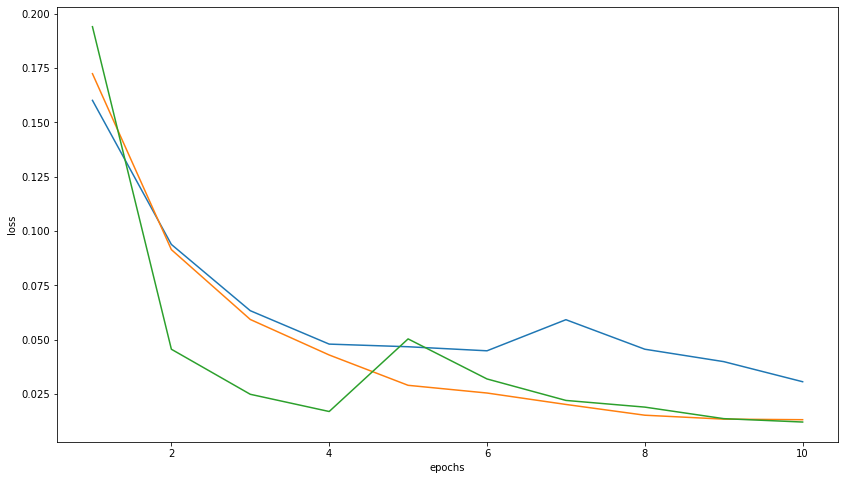

In [68]:
f, a = plt.subplots(1, 1, figsize = (14, 8))

fast_train_loss_plot(loss_unbalanced, a) # blue
fast_train_loss_plot(loss_stratified, a) # orange
fast_train_loss_plot(loss_upscaled, a)   # green

In [69]:
bool_save = True

if bool_save:
    import os
    torch.save(model.state_dict(), os.getcwd() + os.sep + 'RNN_upscaled_data.pth')

https://drive.google.com/open?id=1NVWdfRirQKAyeIXCz17NiBNLrvUyoO6C

## Task

1. Make a dataset balanced: for example select all of the obscene messages, calculate its number and sample from the clean 
messages equal number of examples. **(1)See if it increased your score on toxic messages.** 

As the **additional** task you can modify your dataset sampling during the training/testing. Read about Datasets, DataSamplers and DataLoaders in pytorch. Try to apply them. 


2. Read about RNNs different types (LSTMs and GRUs): 
  https://colah.github.io/posts/2015-08-Understanding-LSTMs/  

  https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21 
  
  **(2)What is the difference between RNN and LSTM? Why do we need LSTM? Explain it in your own words.**  
  
  **(3)What is the difference between LSTM and GRU? Explain it in your own words.** 
  
  
3. Modify your network to make it possible to work with nn.LSTM or nn.GRU layers. (Their outputs may be a little bit defferent from nn.RNN, so be careful to modify your code accordingly). 

4. Compare all of the previous examples: classification with RNN (or LSTM/GRU) and FFNN. **(4)Which one performed better according to the metrics? (5)To the time?**

5. **(6)How dataset imbalancing are influencing your model? Read about dataset imbalancing and about possibilities to handle them. (7)Write down below what can we do with it, or implement a solution.** 
  
  

Please, answer the questions 1-7 and write your answers down below: 

1. Ответ дан немного раньше. Если кратко - помогло. Но этого недостаточно, можно большего добиться.
2. В LSTM реализована модель краткросрочной памяти
3. Похожи, но у GRU меньше параметров.
4. RNN чувствительна к структуре данных для обучения. Следовательно, измерения тоже от этого зависят. Чем хуже сформирована обучающая выборка, тем хуже результаты. В случае FFNN чуть более гладко.
5. Исходя из проделанного в этой блокноте, хочется утверждать, что модель RNN учится дольше модели FFNN. Это объясняется сложностью первой структуры. Петли сети, повторные расчёты, усложнённая форма измерения ошибки - это некоторые факторы влияния на картину.
6. Интуитивно ясно, что существует прямая зависимость между качеством собранных данных для модели и её итоговыми показателями. Объём категориальных данных, структура словаря как то, на что необходимо обратить внимание.
7. Проблему о слабо сбалансированном наборе данных можно решить двумя основными способами. Первым способом будет создание районированной выборки из исходной, вторым - искусственный метод увеличения объёма малого подмножества выборки (по сравнению с количеством остальных данных в ней). Только послнеднее нужно делать с умом и это далеко не всегда спасает.